# Проект: вариант 2
### Задание 3.

**Условие**  
3.1 Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.  
3.2 Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [140]:
import pandas as pd
import requests
from urllib.parse import urlencode

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings. filterwarnings('ignore')

In [154]:
def add_info_and_calc_metrics(path):
    
    # загружаем новый файл
    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=path))
    response = requests.get(final_url)
    download_url = response.json()['href']
    download_response = requests.get(download_url)
    with open('groups_add.csv', 'wb') as f:
        f.write(download_response.content)
    
    # считываем файлы в датафреймы
    
    groups = pd.read_csv('groups.csv', sep=';')
    groups_add = pd.read_csv('groups_add.csv', sep=',')
    active_studs = pd.read_csv('active_studs.csv', sep=',')
    checks = pd.read_csv('checks.csv', sep=';')
    
    # Проверяем новый файл на соответствие колонок и типов данных файлу groups.csv
    
    if groups.shape[1] == groups_add.shape[1]:
        if(all(groups_add.iloc[:, [1]].dtypes == object) and all(groups_add.iloc[:, [0]].dtypes == 'int64')):
    
            # соединим данные о принадлежности пользователя к контрольной или экспериментальной группе
        
            all_users = groups.append(groups_add)
            print('Слияние прошло успешно')
        else:
            print('Проверить новый файл')
    else:
        print('Проверить новый файл')
        
    # обогатим полученный датасет данными об активности и покупках
    active_studs['active'] = 1
    checks['purch'] = 1
    
    # Добавим в один датафрейм данные 
    df = all_users.merge(active_studs, how='outer', left_on='id', right_on='student_id').fillna(0)
    df = df.merge(checks, how='outer', left_on='id', right_on='student_id').fillna(0)
    df = df[['id', 'grp', 'active', 'rev', 'purch']]
    
    # Для расчета и анализа метрик возьмем только активных пользователей
    df_active = df[df['active'] == 1]
    
    # Конверсия в активного пользователя для группы A
    CR_A = round(df_active.query("grp == 'A'").id.count() / all_users.query("grp == 'A'").id.count() * 100, 2)
    
    # Конверсия в активного пользователя для группы В
    CR_B = round(df_active.query("grp == 'B'").id.count() / all_users.query("grp == 'B'").id.count() * 100, 2)
    
    # Конверсия в покупку для группы A
    CR_p_A = df_active.query("purch == 1 and grp == 'A'").id.count() / df_active.query("grp == 'A'").id.count() * 100
    
    # Конверсия в покупку для группы В
    CR_p_B = df_active.query("purch == 1 and grp == 'B'").id.count() / df_active.query("grp == 'B'").id.count() * 100
    
    # Расчитаем ARPPU и медианный чек по группам
    Metrics_group = df_active.query('purch == 1').groupby('grp').agg({'rev': ['mean', 'median']}).round(2)
    Metrics_group.columns = ["_".join(x) for x in Metrics_group.columns.ravel()]
    Metrics_group.rename(columns={'grp_': 'grp', 'rev_mean': 'ARPPU', 'rev_median': 'median_check'}, inplace=True)
    
    # Соберем метрики в один датафрейм
    CR_purch = pd.DataFrame({'grp': ['A', 'B'], 'CR_active': [CR_A, CR_B], 'CR_purch': [CR_p_A, CR_p_B]})
    Metrics_group = Metrics_group.merge(CR_purch, right_on='grp', left_on='grp')
    
    return Metrics_group

In [155]:
add_info_and_calc_metrics('https://disk.yandex.ru/d/3aARY-P9pfaksg')

Слияние прошло успешно


,grp,ARPPU,median_check,CR_active,CR_purch
0,A,933.59,585.0,10.47,5.07
1,B,1257.88,1140.0,11.36,4.62


In [156]:
df = add_info_and_calc_metrics('https://disk.yandex.ru/d/3aARY-P9pfaksg')

Слияние прошло успешно


In [157]:
def plot_metrics(df):
    # построим графики по метрикам
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(25, 15))
    sns.barplot(x=df.grp, y=df.ARPPU, ax=ax[0][0], palette="rocket").set_title('ARPPU')
    sns.barplot(x=df.grp, y=df.median_check, ax=ax[0][1], palette="rocket").set_title('Median check')
    sns.barplot(x=df.grp, y=df.CR_active, ax=ax[1][0], palette="rocket").set_title('CR active')
    sns.barplot(x=df.grp, y=df.CR_purch, ax=ax[1][1], palette="rocket").set_title('CR purches');

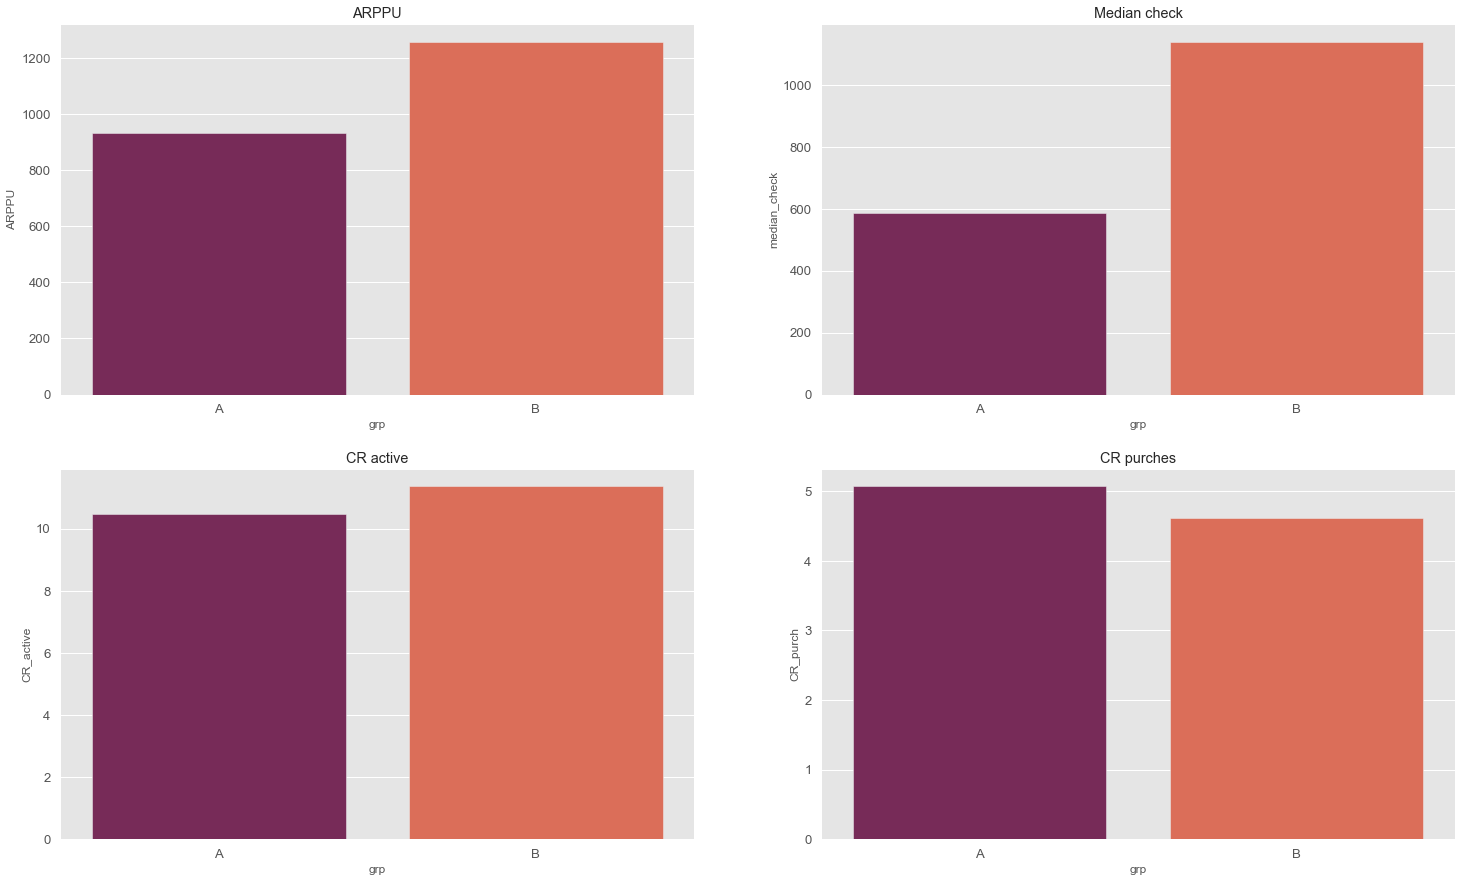

In [158]:
plot_metrics(df)